# Changeover

calculated using BATCHACTIVE and CNTR_GOOD files

In BATCHACTIVE: -1 is active, 0 is inactive

So, if it was -1 and is now 0, we've just started a changeover

In CNTR_GOOD: 0 is stopped, and as soon as it increases changeover has finished

In [14]:
import pandas as pd
import numpy as np
import os
from glob import iglob

from datetime import datetime
import matplotlib.pyplot as plt

# my modules
import set_config


In [15]:
# call set_config
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_local = set_config.ConfigSectionMap("SectionOne")['local']

In [16]:
# function to read in files we need into a generic df
def create_df_from_file(indir, infolder, infilesearch):
    folder = infolder
    path = os.path.join(indir, folder)

    # strptime will retain more of the microseconds
    dateparse = lambda x: datetime.strptime(x, '%d-%b-%y %H:%M:%S.%f')

    df = []
    df_created = pd.DataFrame()

    for filename in iglob(path + '/**/*' + infilesearch + '*', recursive=True):
        df = pd.read_csv(filename, parse_dates=['IP_TREND_TIME'], date_parser=dateparse)
        df = pd.read_csv(filename)
        df_created = df_created.append(df)
    return df_created

In [17]:
# CHANGEOVER
folder = 'IP21_data'

df_BATCHACTIVE = create_df_from_file(dir_sanofi_share, folder, "36680902_BATCHACTIVE")

df_CNTR_GOOD = create_df_from_file(dir_sanofi_share, folder, "36680902_CNTR_GOOD")

# get the batch size from MATNO
df_MATNO = create_df_from_file(dir_sanofi_share, folder, "36650901_MATNO")


df_CNTR_GOOD.sort_values('IP_TREND_TIME', inplace=True)
df_BATCHACTIVE.sort_values('IP_TREND_TIME', inplace=True)
df_MATNO.sort_values('IP_TREND_TIME', inplace=True)

In [21]:
df_changeover = []
# find where previous row was -1 (active) and this row is 0 (inactive) - this is the start of changeover
df_changeover = df_BATCHACTIVE[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_BATCHACTIVE['IP_TREND_VALUE'].shift(1) == -1) & (df_BATCHACTIVE['IP_TREND_VALUE'] == 0)]

# find where previous row was 0 (batch not started) and this row is >0 (batch running) - changeover has finished
df_changeover = df_changeover.append(df_CNTR_GOOD[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_CNTR_GOOD['IP_TREND_VALUE'].shift(1) == 0) & (df_CNTR_GOOD['IP_TREND_VALUE'] > 0)])
# convert IP_TREND_TIME to datetime format before sorting, otherwise doesn't work as expected
df_changeover['IP_TREND_TIME'] = pd.to_datetime(df_changeover['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_changeover.sort_values('IP_TREND_TIME', inplace=True)

# now, in case there are many BATCHACTIVEs for 1 CNTR_GOOD, only get the first BATCHACTIVE (>0) after a batch reset (0)
df_changeover2 = df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 0) & (df_changeover['IP_TREND_VALUE'] > 0)]
df_changeover2 = df_changeover2.append(df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 1) & (df_changeover['IP_TREND_VALUE'] == 0)])

# add the first row of changeover if it is a BATCHACTIVE, otherwise it gets dropped by above logic
df_changeover2 = df_changeover2.append(df_changeover[:1].loc[df_changeover[:1].Name == '36680902_BATCHACTIVE'])

# convert dates to datetime format
df_changeover2['IP_TREND_TIME'] = pd.to_datetime(df_changeover2['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_changeover2.sort_values('IP_TREND_TIME', inplace=True)


# find the speed and time diff, turn into minutes
df_changeover2['time_diff_mins'] = df_changeover2.IP_TREND_TIME.diff().dt.seconds / 60
df_changeover2['time_diff_mins'].fillna(0, inplace=True)
df_changeover2['time_diff_mins'] = np.array(df_changeover2['time_diff_mins'], dtype=int)
# df_changeover2.set_index('IP_TREND_TIME', inplace=True)

# reshape the changeover dataframe so that we have a start and end time on 1 line - easier for charting later
df_changeover3 = pd.DataFrame({'start':df_changeover2.IP_TREND_TIME.iloc[::2].values, 'end':df_changeover2.IP_TREND_TIME.iloc[1::2].values, 'time_diff_mins':df_changeover2.time_diff_mins.iloc[1::2].values})
for i, row in df_changeover3.iterrows():
    print (i, row[0], row[1])

0 2021-08-02 22:47:04.100000 2021-08-02 23:33:13.200000
1 2021-08-03 19:48:39.600000 2021-08-03 21:08:45.100000
2 2021-08-04 00:56:14.200000 2021-08-04 02:05:46.100000
3 2021-08-04 07:01:24.900000 2021-08-04 07:37:14.500000
4 2021-08-05 20:07:04.200000 2021-08-05 20:50:02
5 2021-08-06 00:30:29.400000 2021-08-06 03:04:38.500000
6 2021-08-06 11:04:49.200000 2021-08-06 12:55:08.100000
7 2021-08-07 01:48:36.400000 2021-08-07 03:10:52.900000
8 2021-08-10 09:33:14.700000 2021-08-10 10:49:15.300000
9 2021-08-12 10:17:53 2021-08-12 11:01:49
10 2021-08-12 16:07:40.400000 2021-08-12 19:32:39.600000
11 2021-08-16 09:27:53.300000 2021-08-16 10:27:43.600000
12 2021-08-18 11:46:40.400000 2021-08-18 12:57:14
13 2021-09-02 12:19:28.200000 2021-09-02 13:22:38.700000
14 2021-09-03 21:28:44.200000 2021-09-03 22:42:38.400000
15 2021-09-04 03:19:34.700000 2021-09-04 04:36:38.500000
16 2021-09-04 08:37:57.800000 2021-09-04 10:16:56.400000
17 2021-09-04 15:20:04.900000 2021-09-04 15:54:10.100000
18 2021-09-0

In [ ]:
df_changeover2.set_index('IP_TREND_TIME', inplace=True)

Text(0, 0.5, 'Changeover stop time')

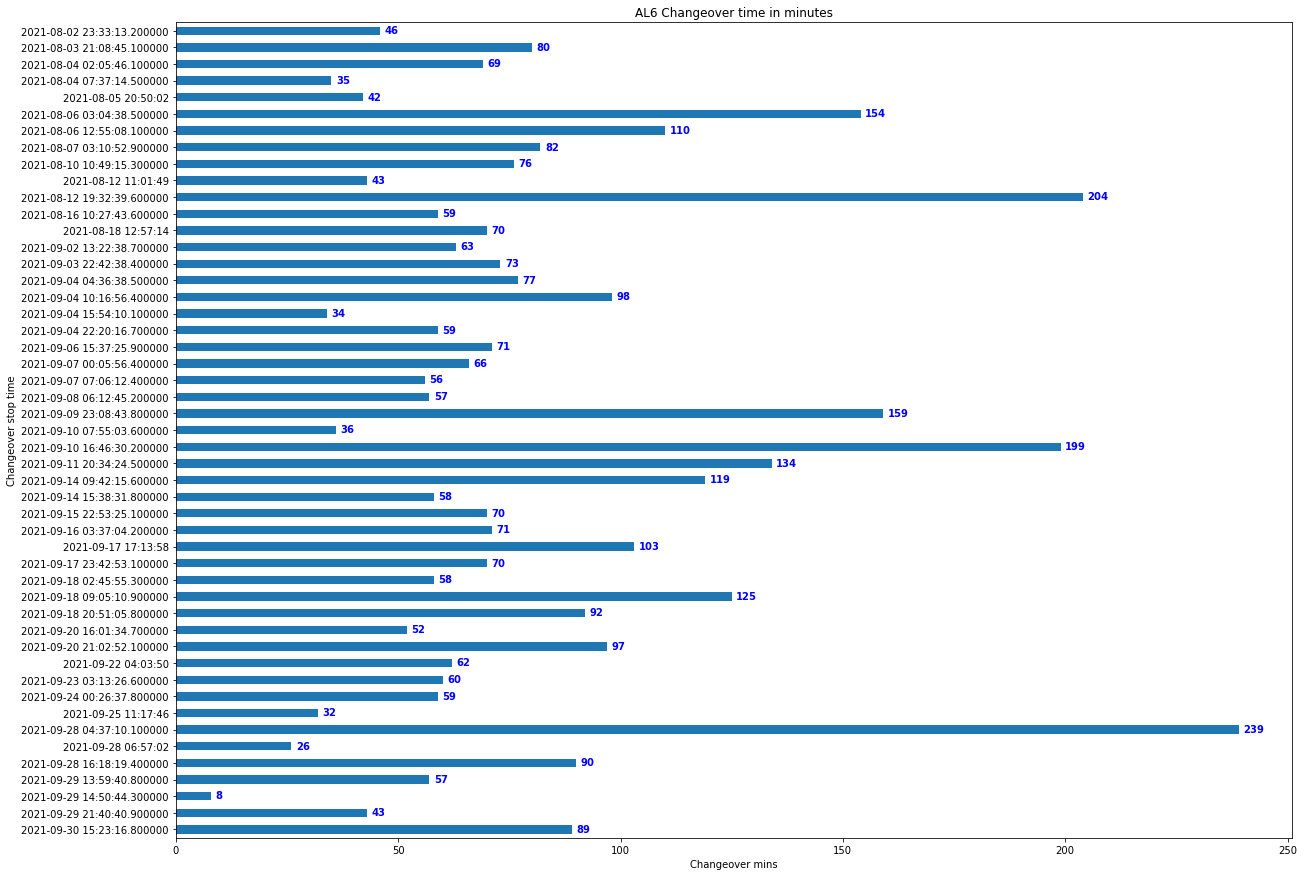

In [36]:

# group_unstacked = df_changeover.groupby([pd.Grouper(freq='D'), 'IP_TREND_VALUE'])['time_diff_secs'].sum().unstack(level=1)
# group_unstacked.set_index('IP_TREND_TIME', inplace=True)
# group_unstacked.plot.area(figsize=(17,10))

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

df_changeover2[df_changeover2.IP_TREND_VALUE == 1]['time_diff_mins'].sort_index(ascending=False).plot.barh(ax=ax)

for i, v in enumerate(df_changeover2[df_changeover2.IP_TREND_VALUE == 1]['time_diff_mins'].sort_index(ascending=False)):
    ax.text(v + 1, i - .15, str(v), color='blue', fontweight='bold')

ax.set_title('AL6 Changeover time in minutes')
ax.set_xlabel('Changeover mins')
ax.set_ylabel('Changeover stop time')